# Beacons dataset
1. Preprocessing of dataset
2. Clustering

In [1]:
import pandas as pd
import numpy as np

from lib.preprocessing import *
from lib.clustering import * 

from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# The Dataset

Loading the dataset

In [2]:
beacons = pd.read_csv("beacons_dataset.csv", delimiter=';')
beacons.head()

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor


In [3]:
beacons.dtypes

part_id    object
ts_date     int64
ts_time    object
room       object
dtype: object

In [4]:
pd.set_option("display.max_columns", None)
beacons

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor
...,...,...,...,...
58628,2138,20181202,17:39:27,Kitchen
58629,2138,20181202,20:09:08,Bedroom
58630,2138,20181202,20:21:52,Kitchen
58631,2138,20181203,06:46:44,Sittingroom


# Preprocessing 

1. Keep correct users (Only those with 4 digits)
2. Corrert room labels 
3. Calculating time spent on each room per partipant 

In [5]:
beacons_correct = keep_correct_users(beacons)
beacons_correct.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor


In [6]:
beacons_correct.isnull().sum()

part_id    0
ts_date    0
ts_time    0
room       0
dtype: int64

In [7]:
beacons_correct = correct_room_labels(beacons_correct)

In [8]:
beacons_correct['room'].unique()

array(['Kitchen', 'Bedroom', 'Outdoor', 'Bathroom', 'Livingroom', 'Hall',
       'Office', 'Dinningroom', 'One', 'three', 'Four', 'Box', 'Storage',
       'Laundry'], dtype=object)

In [9]:
column_names = ['part_id', 'Bedroom', 'Bathroom', 'Kitchen', 'Livingroom']
beacons_room_time = pd.DataFrame(columns = column_names)
beacons_room_time['part_id'] = pd.Series(beacons_correct['part_id'].unique())
beacons_room_time.sort_values('part_id', inplace=True)
beacons_room_time.reset_index(inplace=True)
beacons_room_time.drop(["index"], axis=1, inplace=True)
beacons_room_time.head(5)

,part_id,Bedroom,Bathroom,Kitchen,Livingroom
0,1001,NaN,NaN,NaN,NaN
1,1003,NaN,NaN,NaN,NaN
2,1005,NaN,NaN,NaN,NaN
3,1006,NaN,NaN,NaN,NaN
4,1007,NaN,NaN,NaN,NaN


In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
beacons_correct = beacons_correct.sort_values(by= ['part_id', 'ts_date', 'ts_time'], ignore_index= True)
beacons_correct.head(5)

,part_id,ts_date,ts_time,room
0,1001,20171021,14:45:30,Outdoor
1,1001,20171101,14:07:11,Livingroom
2,1001,20171107,15:37:59,Livingroom
3,1001,20171117,15:52:46,Livingroom
4,1001,20171117,15:52:58,Bathroom


In [11]:
beacons_room_time = generate_new_features(beacons_correct, beacons_room_time)

In [12]:
beacons_room_time.head(10)

,part_id,Bedroom,Bathroom,Kitchen,Livingroom
0,1001,14.3,2.9,11.5,26.7
1,1003,0.0,3.5,2.7,77.0
2,1005,0.0,0.0,0.0,54.3
3,1006,9.9,37.6,31.2,10.7
4,1007,9.7,0.7,74.8,9.9
5,1022,4.3,0.0,1.7,89.9
6,1023,0.0,0.0,55.8,41.4
7,1030,16.5,0.0,16.0,48.7
8,1035,0.0,0.5,4.6,40.6
9,1036,0.0,0.0,0.0,23.2


In [13]:
beacons_room_time.fillna(0.00, inplace= True)

In [14]:
beacons_room_time.to_csv('beacons_cleared.csv', index = False)

In [15]:
beacons_room_time['part_id'] = beacons_room_time['part_id'].astype(int)

In [16]:
clinical = pd.read_csv('final_clinical_data.csv', delimiter= ',')
clinical['part_id'] = clinical['part_id'].astype(int)
clinical.head()


,part_id,raise_chair_time,balance_single,gait_get_up,gait_speed_4m,bmi_body_fat,cognitive_total_score,social_text,health_rate,activity_regular,fried
0,1001,13.0,1,18.0,7.0,30.4,25.0,0.0,2,1,1
1,1002,16.0,1,60.0,11.0,23.4,27.0,0.0,2,1,2
2,1003,10.0,1,21.0,11.0,32.8,26.0,10.0,3,0,2
3,1004,3.0,0,24.7,14.3,24.5,23.0,0.0,2,0,0
4,1005,13.0,0,42.0,8.0,29.6,24.0,0.0,2,2,2


In [17]:
merged_dataset = pd.merge(left=beacons_room_time, right=clinical, how='left', left_on='part_id', right_on='part_id')
merged_dataset.dropna(inplace= True)
merged_dataset.head()

,part_id,Bedroom,Bathroom,Kitchen,Livingroom,raise_chair_time,balance_single,gait_get_up,gait_speed_4m,bmi_body_fat,cognitive_total_score,social_text,health_rate,activity_regular,fried
0,1001,14.3,2.9,11.5,26.7,13.0,1.0,18.0,7.0,30.4,25.0,0.0,2.0,1.0,1.0
1,1003,0.0,3.5,2.7,77.0,10.0,1.0,21.0,11.0,32.8,26.0,10.0,3.0,0.0,2.0
2,1005,0.0,0.0,0.0,54.3,13.0,0.0,42.0,8.0,29.6,24.0,0.0,2.0,2.0,2.0
3,1006,9.9,37.6,31.2,10.7,12.0,1.0,18.0,6.0,23.4,26.0,21.0,4.0,1.0,1.0
4,1007,9.7,0.7,74.8,9.9,10.0,1.0,13.0,3.0,29.4,26.0,0.0,3.0,1.0,1.0


In [18]:
df = pd.read_csv('clinical_full.csv', delimiter=',')
df_merged = pd.merge(left=beacons_room_time, right=df, how='left', left_on='part_id', right_on='part_id')
df_merged.dropna(inplace= True)

In [19]:
merged_dataset.to_csv('merged_dataset.csv', index = False)

In [20]:
X = merged_dataset[list(merged_dataset.columns)]
y = merged_dataset['fried']
X.drop(['fried', 'part_id'], inplace = True, axis = 1)

In [21]:
scaler = MinMaxScaler()
merged_dataset_scaled = scaler.fit_transform(merged_dataset)

In [22]:
X = X.astype(float)
X = X.to_numpy()

# Clustering

Clustering using: 

1. KMeans 
2. Spectral Clustering
3. KMeans with PCA

and calculating Silhouette score for each model.

In [23]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

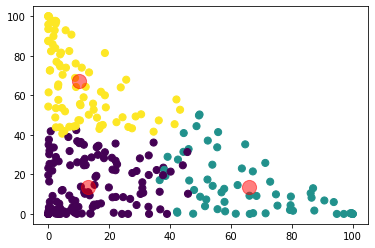

In [24]:
plt.scatter(X[:, 2], X[:, 3], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.5)

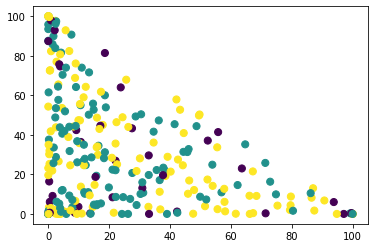

In [25]:
plt.scatter(X[:, 2], X[:, 3], c=y, s=50, cmap='viridis')

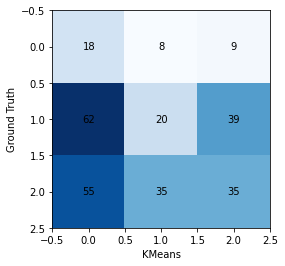

In [26]:
kmeans_cm = create_clustering_confusion_matrix(y, y_kmeans, "KMeans")


In [27]:
kmeans_score = silhouette_score(X, y_kmeans)
print('Silhouette score of KMeans: {:.5f}'
     .format(kmeans_score))

Silhouette score of KMeans: 0.29432


In [28]:
spec_clust = SpectralClustering(n_clusters= 3, assign_labels="discretize", affinity = "nearest_neighbors", n_neighbors= 20).fit(X)

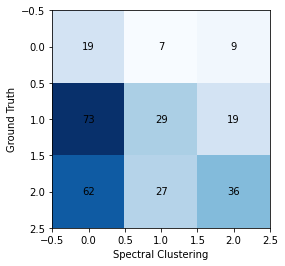

In [29]:
spect_clust_cm = create_clustering_confusion_matrix(y, spec_clust.labels_, "Spectral Clustering")

In [30]:
spec_clust_score = silhouette_score(X, spec_clust.labels_)
print('Silhouette score of KMeans: {:.5f}'
     .format(spec_clust_score))

Silhouette score of KMeans: 0.27509


In [31]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

In [32]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(X_pca)
y_kmeans_pca = kmeans_pca.predict(X_pca)

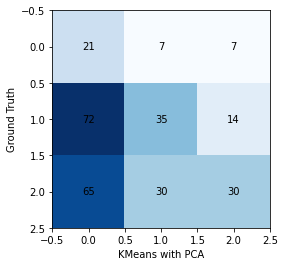

In [33]:
kmeans_pca_cm = create_clustering_confusion_matrix(y, y_kmeans_pca, "KMeans with PCA")

In [34]:
kmeans_pca_score = silhouette_score(X_pca, y_kmeans_pca)
print('Silhouette score of KMeans: {:.5f}'
     .format(kmeans_pca_score))

Silhouette score of KMeans: 0.59354
